# MLP
Like MLP_207 with K=5 and epochs=200.

Use GMM for threshold.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-29 21:50:33.458927


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TAILS_TRAIN  = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TRAIN = False
FILTER_MIDDLE_TEST  = False
FILTER_NONE         = True

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-29 21:51:07.259369
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                65664     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_NONE or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_NONE or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-29 21:51:08.126784
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-29 21:51:31.772626

Training # 1 1
2023-03-29 21:51:31.774715
2023-03-29 21:51:31.774815
Discriminator is GMM
Means [-0.021984070700750723, -2.5130109773878346]
Variances [1.50516956 2.15414798]
Priors [0.57936818 0.42063182]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2153:1346 61.53%
Computed class weights: {0: 1.299777117384844, 1: 0.8125870877844867}
Valid 1:0 538:332 61.84%
FIT
2023-03-29 21:51:33.278716


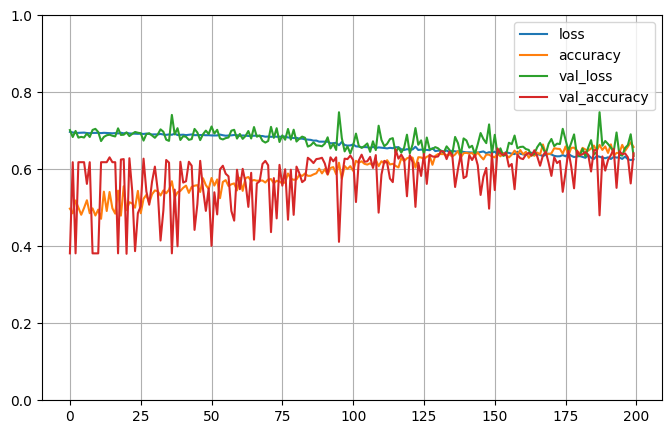


2023-03-29 21:53:05.955158

Testing # 1 1
2023-03-29 21:53:05.955387
2023-03-29 21:53:05.955524
PREDICT
2023-03-29 21:53:05.974861
Test 1:0 538:332 61.84%
Predict 1:0 696:174 80.00%
Test sizes (870, 1025) (870,)
Range of scores: 0.020573724 to 0.97060496
Score threshold 0.5
Confusion matrix
 [[ 97 235]
 [ 77 461]]
Normalized matrix
 [[0.11149425 0.27011494]
 [0.08850575 0.52988506]]


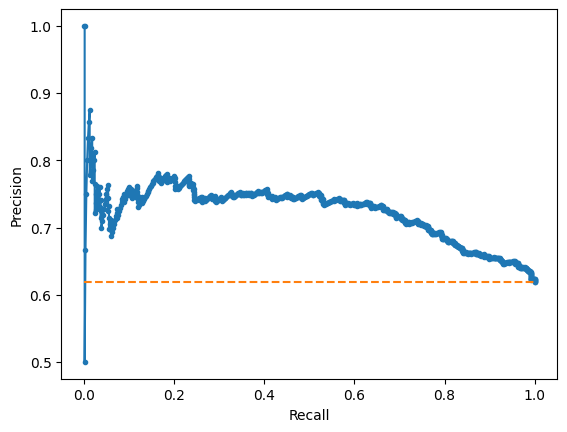

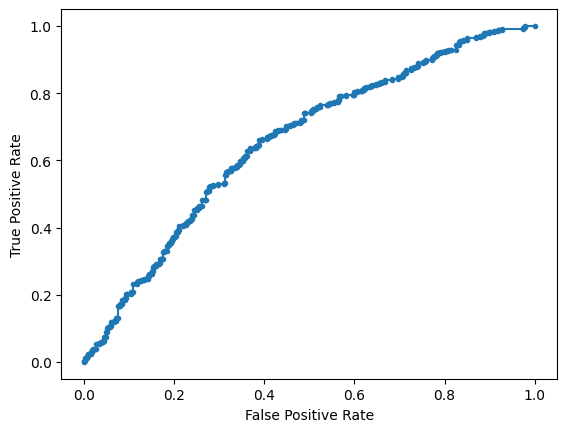

Accuracy: 64.14% Precision: 66.24% Recall: 85.69%
F1: 74.72% MCC: 0.1810
AUPRC: 72.39% AUROC: 65.62%
 accuracy [64.13793103448275]
 precision [66.23563218390804]
 recall [85.68773234200744]
 F1 [74.71636952998378]
 MCC [0.1810094527925786]
 AUPRC [72.38810010706997]
 AUROC [65.62290052402919]
2023-03-29 21:53:07.612757

Training # 1 2
2023-03-29 21:53:07.615097
2023-03-29 21:53:07.615541
Discriminator is GMM
Means [0.00565458631949963, -2.5022412685008932]
Variances [1.48907794 2.28922828]
Priors [0.57480247 0.42519753]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2135:1350 61.26%
Computed class weights: {0: 1.2907407407407407, 1: 0.8161592505854801}
Valid 1:0 529:355 59.84%
FIT
2023-03-29 21:53:10.440174


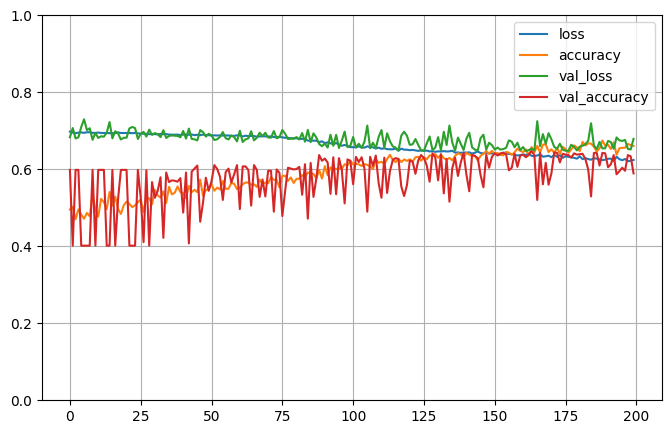


2023-03-29 21:54:42.222111

Testing # 1 2
2023-03-29 21:54:42.222244
2023-03-29 21:54:42.222290
PREDICT
2023-03-29 21:54:42.228714
Test 1:0 529:355 59.84%
Predict 1:0 404:480 45.70%
Test sizes (884, 1025) (884,)
Range of scores: 0.017984333 to 0.9799155
Score threshold 0.5
Confusion matrix
 [[236 119]
 [244 285]]
Normalized matrix
 [[0.26696833 0.13461538]
 [0.2760181  0.32239819]]


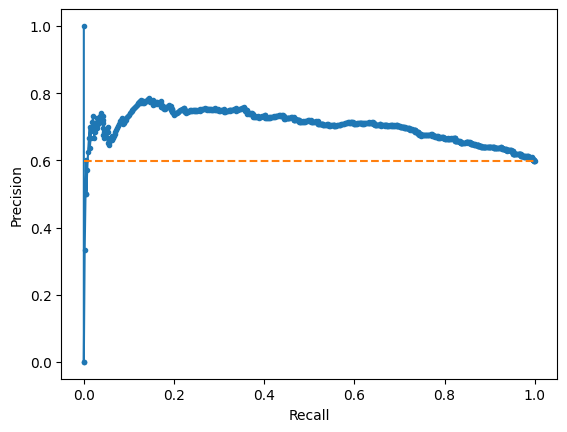

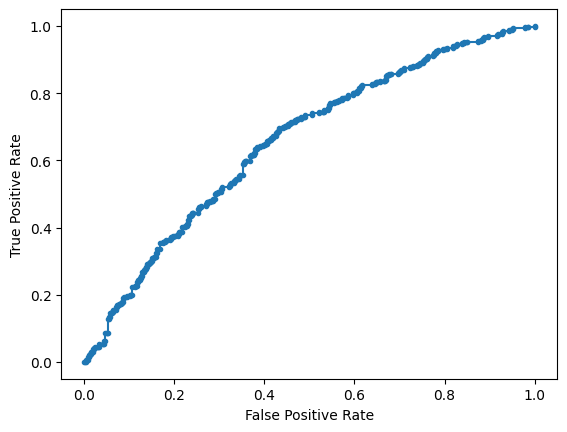

Accuracy: 58.94% Precision: 70.54% Recall: 53.88%
F1: 61.09% MCC: 0.2003
AUPRC: 70.29% AUROC: 65.44%
 accuracy [58.93665158371041]
 precision [70.54455445544554]
 recall [53.875236294896034]
 F1 [61.09324758842444]
 MCC [0.2003008621486496]
 AUPRC [70.29328818927479]
 AUROC [65.43731196251233]
2023-03-29 21:54:43.126571

Training # 1 3
2023-03-29 21:54:43.127293
2023-03-29 21:54:43.127354
Discriminator is GMM
Means [-0.0026252121421639608, -2.489918940535433]
Variances [1.50629361 2.26735568]
Priors [0.57405777 0.42594223]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2149:1371 61.05%
Computed class weights: {0: 1.2837345003646974, 1: 0.8189855746859004}
Valid 1:0 515:334 60.66%
FIT
2023-03-29 21:54:47.140321


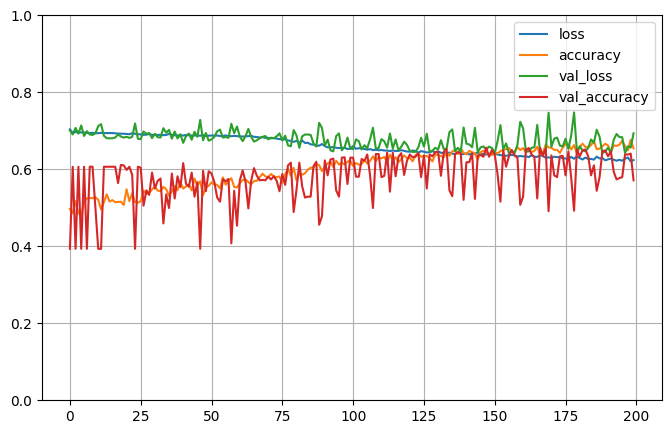


2023-03-29 21:56:18.478253

Testing # 1 3
2023-03-29 21:56:18.478387
2023-03-29 21:56:18.478439
PREDICT
2023-03-29 21:56:18.490358
Test 1:0 515:334 60.66%
Predict 1:0 277:572 32.63%
Test sizes (849, 1025) (849,)
Range of scores: 0.02396194 to 0.95224965
Score threshold 0.5
Confusion matrix
 [[271  63]
 [301 214]]
Normalized matrix
 [[0.31919906 0.07420495]
 [0.35453475 0.25206125]]


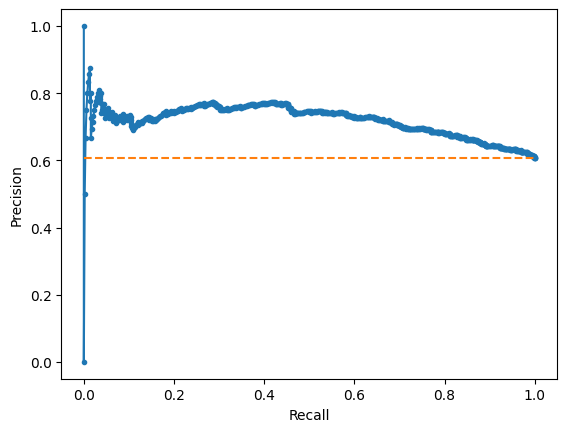

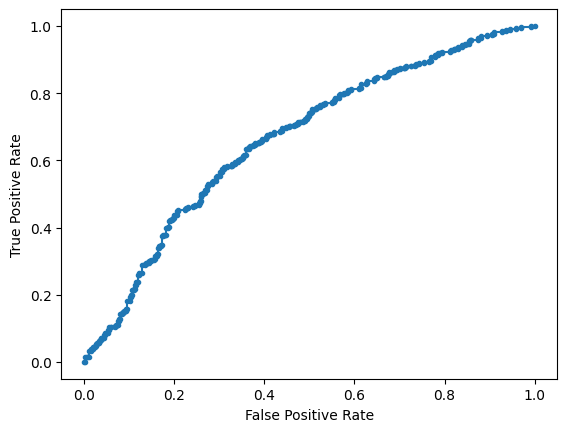

Accuracy: 57.13% Precision: 77.26% Recall: 41.55%
F1: 54.04% MCC: 0.2364
AUPRC: 71.83% AUROC: 66.42%
 accuracy [57.126030624263834]
 precision [77.25631768953069]
 recall [41.55339805825243]
 F1 [54.040404040404034]
 MCC [0.23642583496949704]
 AUPRC [71.82663701547669]
 AUROC [66.41823149816872]
2023-03-29 21:56:19.333853

Training # 1 4
2023-03-29 21:56:19.334966
2023-03-29 21:56:19.335020
Discriminator is GMM
Means [0.011440000735578097, -2.527071518298245]
Variances [1.4816823  2.19513629]
Priors [0.57252372 0.42747628]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2116:1363 60.82%
Computed class weights: {0: 1.2762289068231842, 1: 0.822069943289225}
Valid 1:0 542:348 60.90%
FIT
2023-03-29 21:56:23.446077


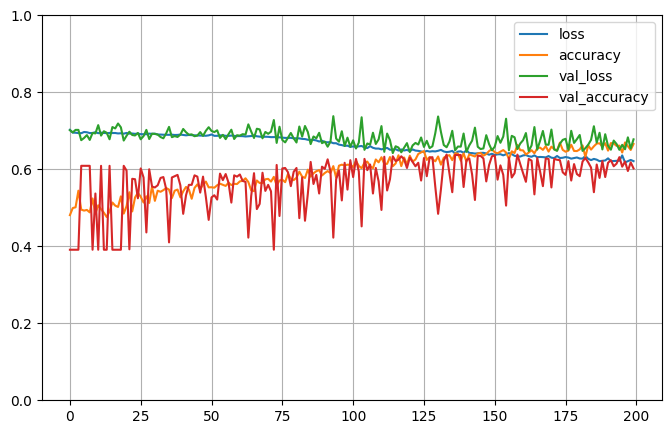


2023-03-29 21:58:46.716120

Testing # 1 4
2023-03-29 21:58:46.716253
2023-03-29 21:58:46.716301
PREDICT
2023-03-29 21:58:46.729056
Test 1:0 542:348 60.90%
Predict 1:0 464:426 52.13%
Test sizes (890, 1025) (890,)
Range of scores: 0.010132364 to 0.9367537
Score threshold 0.5
Confusion matrix
 [[210 138]
 [216 326]]
Normalized matrix
 [[0.23595506 0.15505618]
 [0.24269663 0.36629213]]


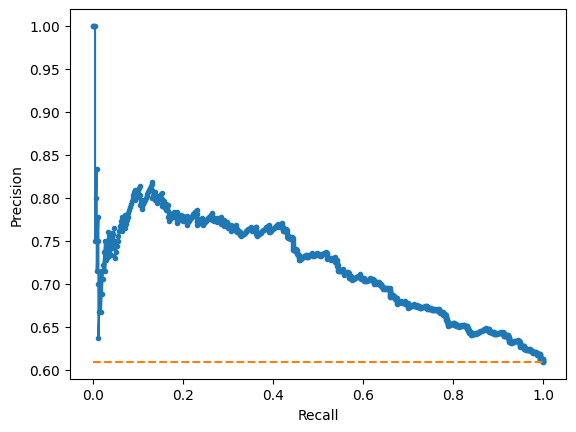

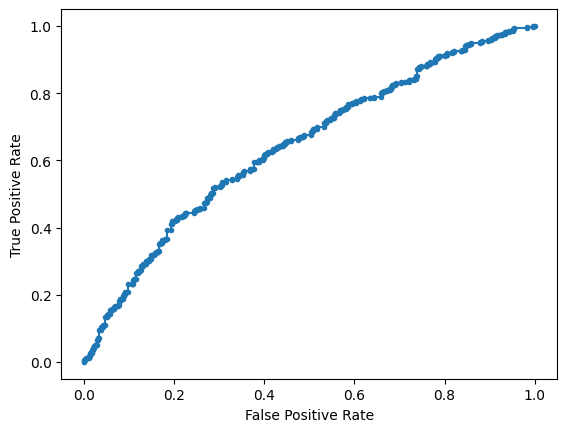

Accuracy: 60.22% Precision: 70.26% Recall: 60.15%
F1: 64.81% MCC: 0.2002
AUPRC: 72.01% AUROC: 64.23%
 accuracy [60.22471910112359]
 precision [70.25862068965517]
 recall [60.147601476014756]
 F1 [64.81113320079523]
 MCC [0.20017918455954095]
 AUPRC [72.01451035498765]
 AUROC [64.2326207744836]
2023-03-29 21:58:47.612268

Training # 1 5
2023-03-29 21:58:47.612499
2023-03-29 21:58:47.612559
Discriminator is GMM
Means [-0.019981441668219767, -2.5421860071426576]
Variances [1.48814443 2.20632461]
Priors [0.57836639 0.42163361]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2145:1348 61.41%
Computed class weights: {0: 1.2956231454005935, 1: 0.8142191142191142}
Valid 1:0 552:324 63.01%
FIT
2023-03-29 21:58:51.640014


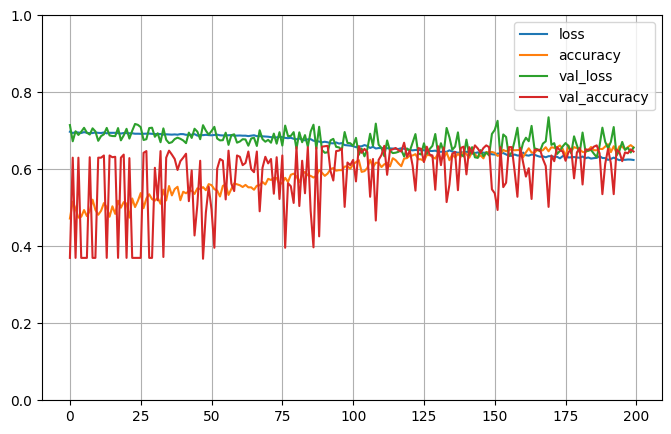


2023-03-29 22:01:14.889408

Testing # 1 5
2023-03-29 22:01:14.891284
2023-03-29 22:01:14.891747
PREDICT
2023-03-29 22:01:14.903880
Test 1:0 552:324 63.01%
Predict 1:0 532:344 60.73%
Test sizes (876, 1025) (876,)
Range of scores: 0.009867378 to 0.9757873
Score threshold 0.5
Confusion matrix
 [[179 145]
 [165 387]]
Normalized matrix
 [[0.2043379  0.16552511]
 [0.18835616 0.44178082]]


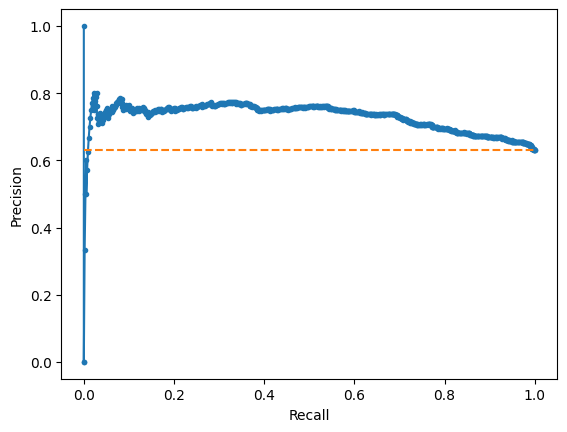

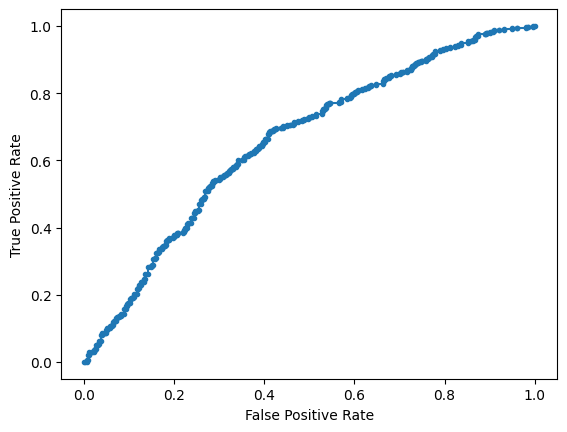

Accuracy: 64.61% Precision: 72.74% Recall: 70.11%
F1: 71.40% MCC: 0.2507
AUPRC: 72.88% AUROC: 65.62%
 accuracy [64.61187214611871]
 precision [72.74436090225564]
 recall [70.1086956521739]
 F1 [71.40221402214021]
 MCC [0.25065770359996237]
 AUPRC [72.88165246828366]
 AUROC [65.62164519592055]
2023-03-29 22:01:15.818109

Training # 2 1
2023-03-29 22:01:15.819765
2023-03-29 22:01:15.820030
Discriminator is GMM
Means [0.007029250118280219, -2.4853421264920206]
Variances [1.44726679 2.21761719]
Priors [0.56111635 0.43888365]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2068:1414 59.39%
Computed class weights: {0: 1.2312588401697313, 1: 0.8418762088974855}
Valid 1:0 553:334 62.34%
FIT
2023-03-29 22:01:17.173087


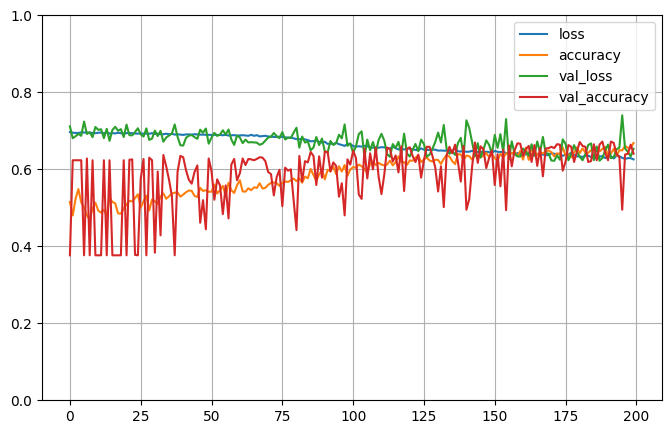


2023-03-29 22:03:40.680727

Testing # 2 1
2023-03-29 22:03:40.680859
2023-03-29 22:03:40.680950
PREDICT
2023-03-29 22:03:40.690008
Test 1:0 553:334 62.34%
Predict 1:0 468:419 52.76%
Test sizes (887, 1025) (887,)
Range of scores: 0.028277464 to 0.981703
Score threshold 0.5
Confusion matrix
 [[217 117]
 [202 351]]
Normalized matrix
 [[0.24464487 0.1319053 ]
 [0.22773393 0.3957159 ]]


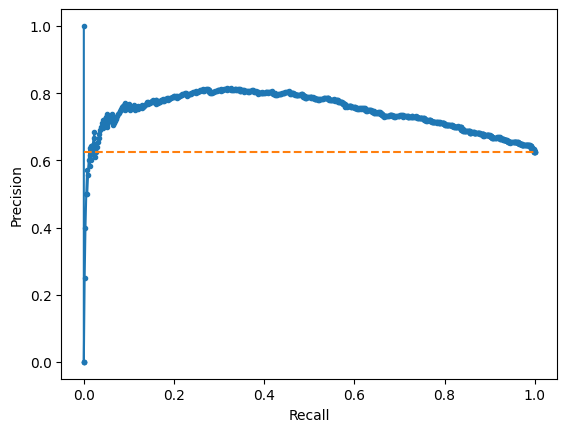

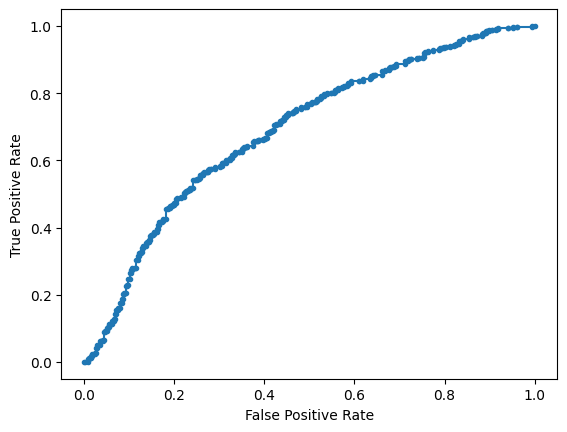

Accuracy: 64.04% Precision: 75.00% Recall: 63.47%
F1: 68.76% MCC: 0.2760
AUPRC: 74.39% AUROC: 68.83%
 accuracy [64.03607666290868]
 precision [75.0]
 recall [63.47197106690777]
 F1 [68.75612144955925]
 MCC [0.276036470464802]
 AUPRC [74.38703518431224]
 AUROC [68.83195634048359]
2023-03-29 22:03:41.553244

Training # 2 2
2023-03-29 22:03:41.554644
2023-03-29 22:03:41.554889
Discriminator is GMM
Means [-0.01335649597785484, -2.505546739361269]
Variances [1.48694738 2.21985481]
Priors [0.57675941 0.42324059]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2153:1348 61.50%
Computed class weights: {0: 1.2985905044510386, 1: 0.8130515559684162}
Valid 1:0 528:340 60.83%
FIT
2023-03-29 22:03:42.823825


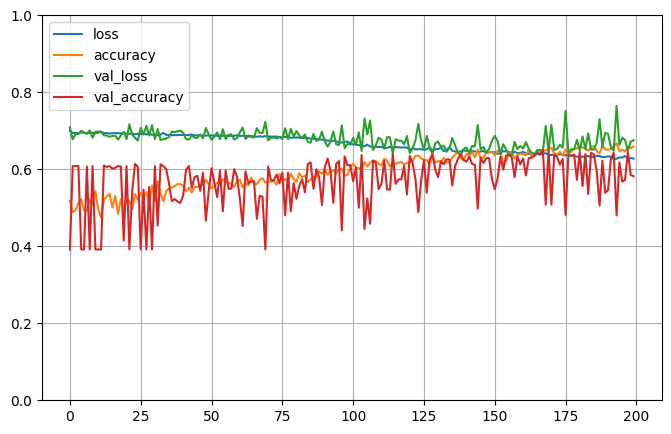


2023-03-29 22:06:06.034452

Testing # 2 2
2023-03-29 22:06:06.036265
2023-03-29 22:06:06.038059
PREDICT
2023-03-29 22:06:06.046391
Test 1:0 528:340 60.83%
Predict 1:0 349:519 40.21%
Test sizes (868, 1025) (868,)
Range of scores: 0.029254964 to 0.9581637
Score threshold 0.5
Confusion matrix
 [[248  92]
 [271 257]]
Normalized matrix
 [[0.28571429 0.10599078]
 [0.31221198 0.29608295]]


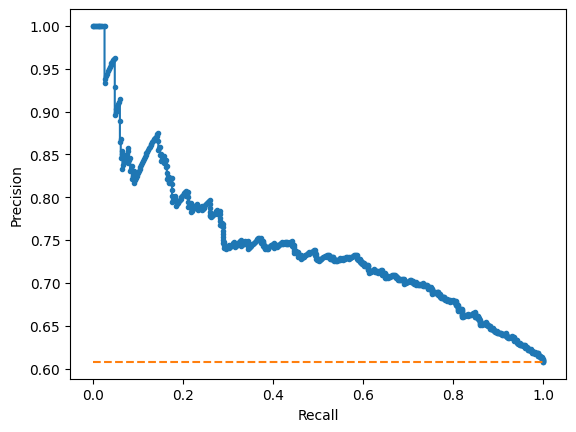

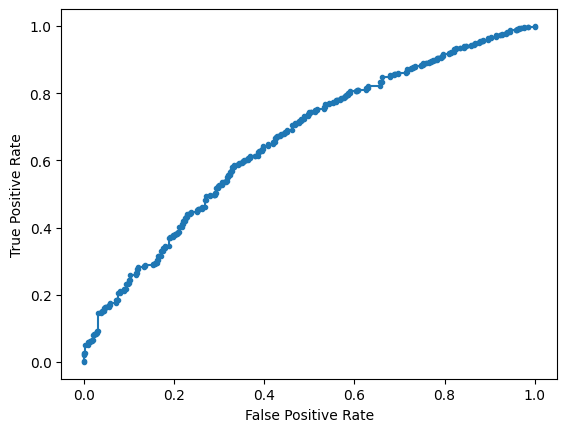

Accuracy: 58.18% Precision: 73.64% Recall: 48.67%
F1: 58.61% MCC: 0.2152
AUPRC: 74.34% AUROC: 65.87%
 accuracy [58.17972350230415]
 precision [73.63896848137536]
 recall [48.67424242424242]
 F1 [58.60889395667047]
 MCC [0.21519079188225104]
 AUPRC [74.33851535918248]
 AUROC [65.87009803921569]
2023-03-29 22:06:06.940575

Training # 2 3
2023-03-29 22:06:06.941964
2023-03-29 22:06:06.942033
Discriminator is GMM
Means [-0.03781001007016538, -2.5635275655845584]
Variances [1.54910884 2.21325292]
Priors [0.58674662 0.41325338]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2191:1318 62.44%
Computed class weights: {0: 1.3311836115326252, 1: 0.8007759014148791}
Valid 1:0 537:323 62.44%
FIT
2023-03-29 22:06:08.219219


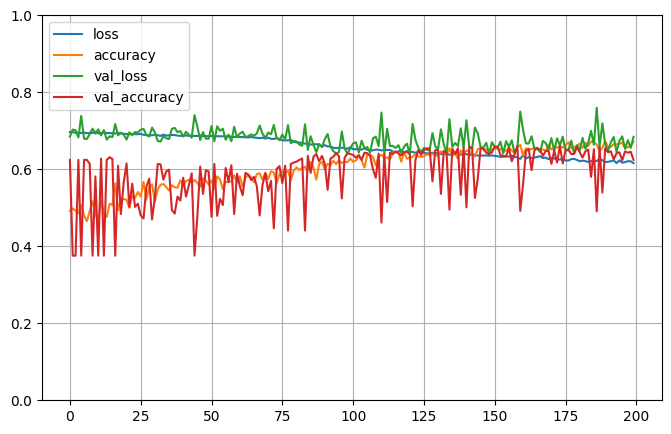


2023-03-29 22:08:31.581161

Testing # 2 3
2023-03-29 22:08:31.582889
2023-03-29 22:08:31.583304
PREDICT
2023-03-29 22:08:31.595482
Test 1:0 537:323 62.44%
Predict 1:0 424:436 49.30%
Test sizes (860, 1025) (860,)
Range of scores: 0.004855954 to 0.9506514
Score threshold 0.5
Confusion matrix
 [[218 105]
 [218 319]]
Normalized matrix
 [[0.25348837 0.12209302]
 [0.25348837 0.37093023]]


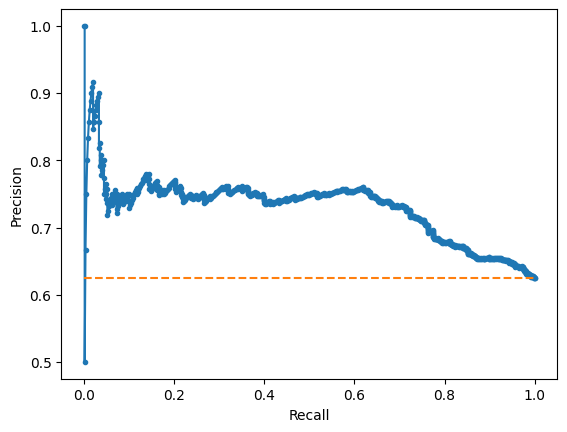

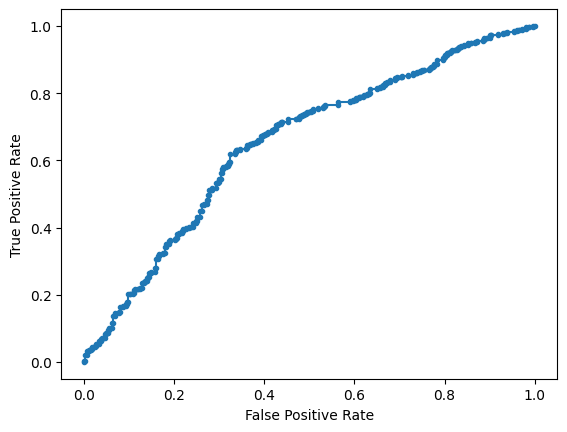

Accuracy: 62.44% Precision: 75.24% Recall: 59.40%
F1: 66.39% MCC: 0.2605
AUPRC: 73.00% AUROC: 65.22%
 accuracy [62.441860465116285]
 precision [75.23584905660378]
 recall [59.40409683426443]
 F1 [66.3891779396462]
 MCC [0.2605287705426489]
 AUPRC [72.99829601081116]
 AUROC [65.22245475667481]
2023-03-29 22:08:32.594324

Training # 2 4
2023-03-29 22:08:32.595491
2023-03-29 22:08:32.595556
Discriminator is GMM
Means [-2.5450147661705227, 0.010236011268788184]
Variances [2.2463908  1.48776208]
Priors [0.41658319 0.58341681]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2167:1323 62.09%
Computed class weights: {0: 1.3189720332577475, 1: 0.8052607291185971}
Valid 1:0 528:351 60.07%
FIT
2023-03-29 22:08:33.880315


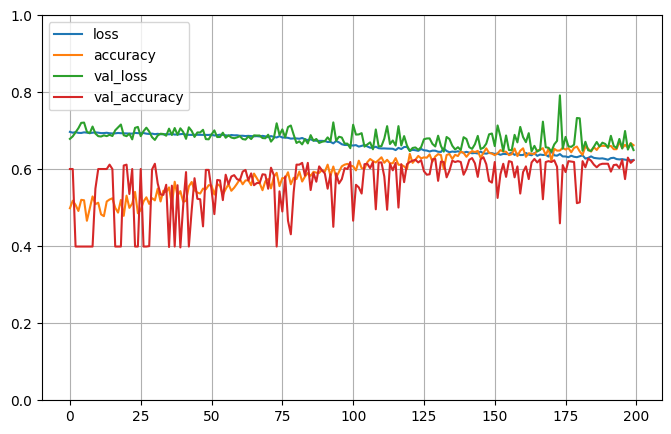


2023-03-29 22:10:58.163355

Testing # 2 4
2023-03-29 22:10:58.165217
2023-03-29 22:10:58.167331
PREDICT
2023-03-29 22:10:58.173173
Test 1:0 528:351 60.07%
Predict 1:0 729:150 82.94%
Test sizes (879, 1025) (879,)
Range of scores: 0.01132566 to 0.9443123
Score threshold 0.5
Confusion matrix
 [[ 85 266]
 [ 65 463]]
Normalized matrix
 [[0.0967008  0.30261661]
 [0.07394767 0.52673493]]


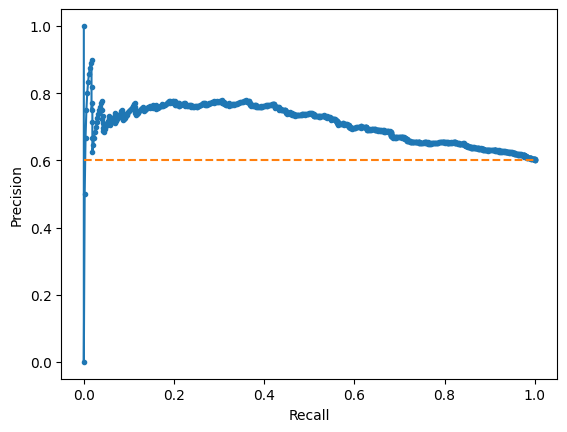

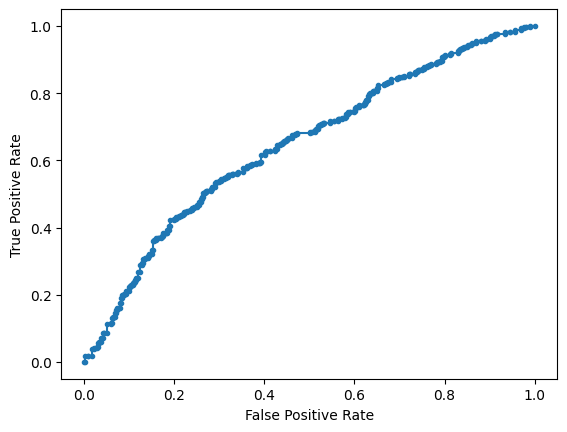

Accuracy: 62.34% Precision: 63.51% Recall: 87.69%
F1: 73.67% MCC: 0.1550
AUPRC: 70.93% AUROC: 64.50%
 accuracy [62.34357224118317]
 precision [63.5116598079561]
 recall [87.68939393939394]
 F1 [73.66746221161496]
 MCC [0.15499725917907556]
 AUPRC [70.93221599356497]
 AUROC [64.49807908141241]
2023-03-29 22:10:59.251308

Training # 2 5
2023-03-29 22:10:59.253615
2023-03-29 22:10:59.254022
Discriminator is GMM
Means [-2.511576408056661, -0.0135756102829319]
Variances [2.18615676 1.51755813]
Priors [0.41844038 0.58155962]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2165:1329 61.96%
Computed class weights: {0: 1.3145221971407073, 1: 0.8069284064665126}
Valid 1:0 529:346 60.46%
FIT
2023-03-29 22:11:02.747435


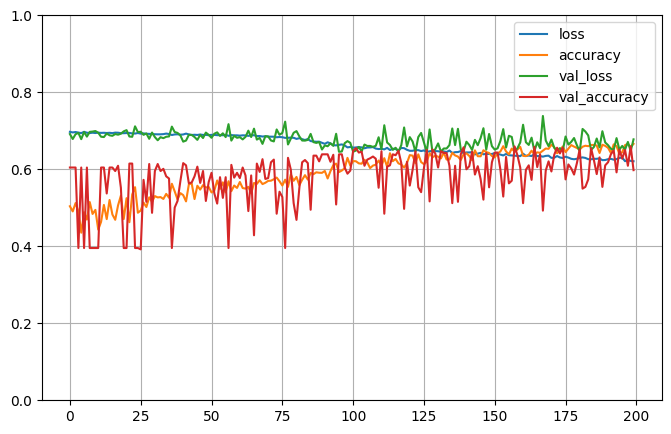


2023-03-29 22:13:26.049751

Testing # 2 5
2023-03-29 22:13:26.050348
2023-03-29 22:13:26.050392
PREDICT
2023-03-29 22:13:26.056972
Test 1:0 529:346 60.46%
Predict 1:0 407:468 46.51%
Test sizes (875, 1025) (875,)
Range of scores: 0.01506304 to 0.97928804
Score threshold 0.5
Confusion matrix
 [[231 115]
 [237 292]]
Normalized matrix
 [[0.264      0.13142857]
 [0.27085714 0.33371429]]


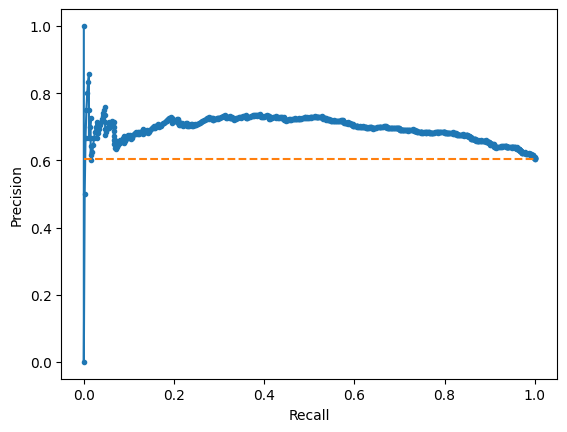

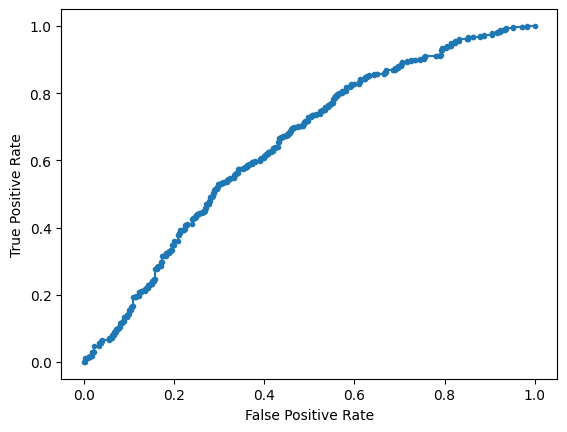

Accuracy: 59.77% Precision: 71.74% Recall: 55.20%
F1: 62.39% MCC: 0.2153
AUPRC: 69.51% AUROC: 64.86%
 accuracy [59.77142857142857]
 precision [71.74447174447175]
 recall [55.19848771266541]
 F1 [62.39316239316239]
 MCC [0.21528195332655403]
 AUPRC [69.51330914109477]
 AUROC [64.85789525443361]
2023-03-29 22:13:26.716186


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 61.18% std 2.69
 precision mean 71.62% std 4.21
 recall mean 62.58% std 14.92
 F1 mean 65.59% std 6.72
 MCC mean 0.22% std 0.04
 AUPRC mean 72.16% std 1.60
 AUROC mean 65.66% std 1.29
 accuracy [[64.13793103448275], [58.93665158371041], [57.126030624263834], [60.22471910112359], [64.61187214611871], [64.03607666290868], [58.17972350230415], [62.441860465116285], [62.34357224118317], [59.77142857142857]]
 precision [[66.23563218390804], [70.54455445544554], [77.25631768953069], [70.25862068965517], [72.74436090225564], [75.0], [73.63896848137536], [75.23584905660378], [63.5116598079561], [71.74447174447175]]
 recall [[85.68773234200744], [53.875236294896034], [41.55339805825243], [60.147601476014756], [70.1086956521739], [63.47197106690777], [48.67424242424242], [59.40409683426443], [87.68939393939394], [55.19848771266541]]
 F1 [[74.71636952998378], [61.09324758842444], [54.040404040404034], [64.81113320079523], [71.40221402214021], [68.75612144955925], [58.60889395667047